#Why Missing Data Breaks Models: The Problem in Action

##Step 1: Setting Up Your Python Environment

In [ ]:
# Essential imports for data handling, visualization, and machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer  # needed for IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.datasets import fetch_california_housing  # California Housing dataset

# Optional: Set style for better visualizations
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

##Step 2: Loading a Dataset with Missing Data

In [ ]:
# Load dataset with missing values

# Load and prepare the California Housing dataset with artificially introduced missing values
from sklearn.datasets import fetch_california_housing
import pandas as pd
import numpy as np

california = fetch_california_housing()
df = pd.DataFrame(
    data=california.data,
    columns=california.feature_names
)
df['MedHouseVal'] = california.target  # Add the target variable

# Introduce random missing values for demonstration
np.random.seed(42)  # For reproducibility
mask = np.random.random(df.shape)

In [ ]:
# Make about 10% of the data missing (mask < 0.1 means ~10% will be True, thus masked)
df_with_missing = df.mask(mask < 0.1) # .mask replaces where the condition is True

# Load the dataset with missing values (Using the generated df directly)
data = df_with_missing.copy()

# Display the first few rows to examine the data structure
# print("Dataset Preview:")
# print(data.head())

# Get basic information about the dataset
# print("\nDataset Info:")
# print(data.info())

# Check for missing values by column (Count)
print("\nMissing Values by Column (Count):")
print(data.isnull().sum())

# Calculate and display missing values percentage by column
print("\nMissing Values by Column (Percentage):")
print((data.isnull().sum() / len(data)) * 100)


Missing Values by Column (Count):
MedInc         2052
HouseAge       2092
AveRooms       2010
AveBedrms      2105
Population     2089
AveOccup       2075
Latitude       2055
Longitude      2079
MedHouseVal    2074
dtype: int64

Missing Values by Column (Percentage):
MedInc          9.941860
HouseAge       10.135659
AveRooms        9.738372
AveBedrms      10.198643
Population     10.121124
AveOccup       10.053295
Latitude        9.956395
Longitude      10.072674
MedHouseVal    10.048450
dtype: float64


##Step 3: Visualizing the Missing Data Problem

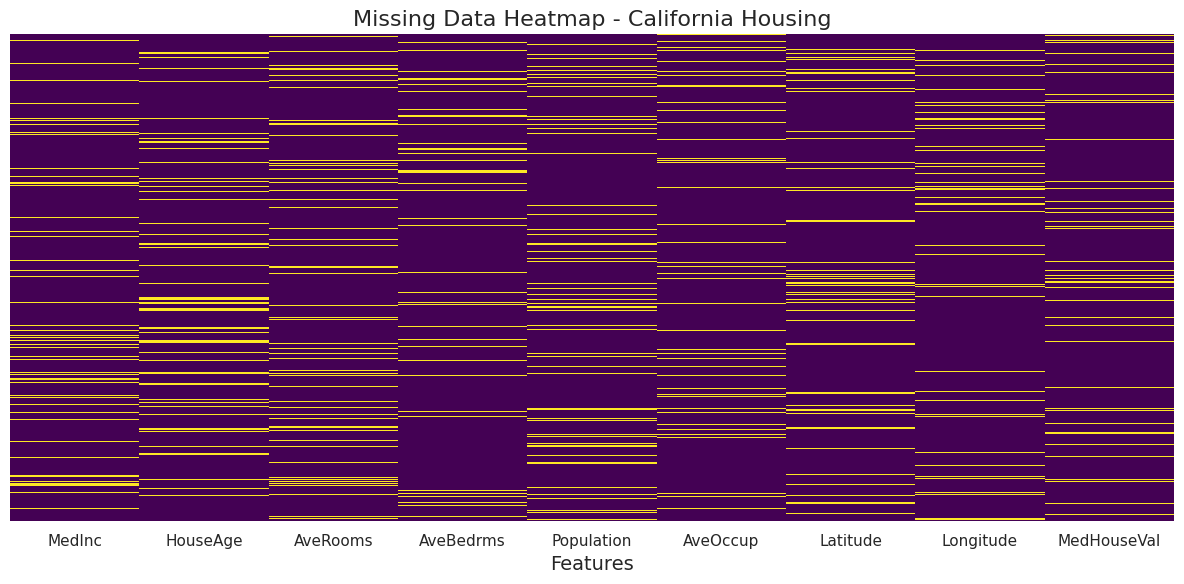

<Figure size 1000x600 with 0 Axes>

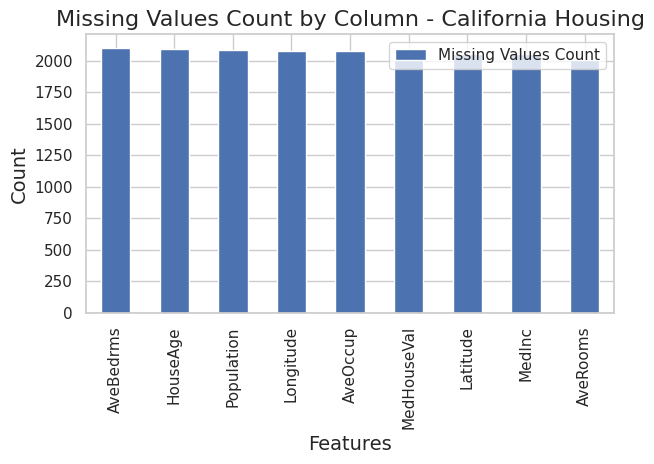

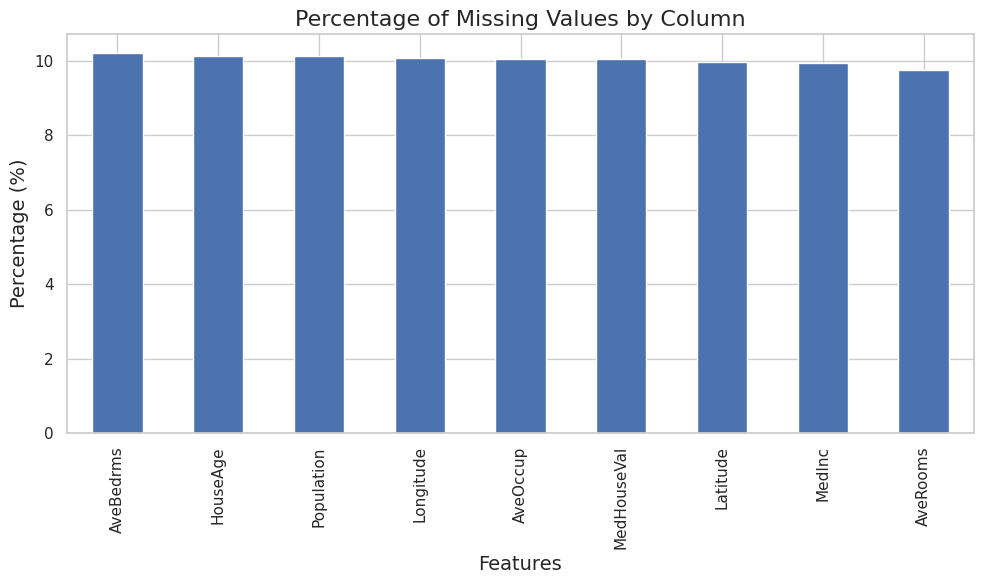

In [ ]:
# Create a clear visualization of missing data
plt.figure(figsize=(12, 6))
sns.heatmap(data.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Data Heatmap - California Housing', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.tight_layout()
plt.show()

# #added during screencast
# Bar chart showing count of missing values per column
plt.figure(figsize=(10, 6))
missing_values = pd.DataFrame(data.isnull().sum(), columns=['Missing Values Count'])
missing_values.sort_values('Missing Values Count', ascending=False, inplace=True)
missing_values.plot.bar()
plt.title('Missing Values Count by Column - California Housing', fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Features', fontsize=14)
plt.tight_layout()
plt.show()

# #added during screencast
# Calculate percentage of missing values per column
missing_pct = data.isnull().mean() * 100
plt.figure(figsize=(10, 6))
missing_pct.sort_values(ascending=False).plot.bar()
plt.title('Percentage of Missing Values by Column', fontsize=16)
plt.ylabel('Percentage (%)', fontsize=14)
plt.xlabel('Features', fontsize=14)
plt.tight_layout()
plt.show()

##Step 4: Attempting to Fit a Model with Missing Data


In [ ]:
# Define features and target variable
features = ['MedInc', 'HouseAge', 'AveRooms']  # Median Income, House Age, Average Rooms
target = 'MedHouseVal'  # Median House Value in $100,000's

# Extract features and target
X = data[features]
y = data[target]

# Create a linear regression model
model = LinearRegression()

# Attempt to fit the model with missing data
print("\nAttempting to fit model with missing data:")
try:
    model.fit(X, y)
    print("Model fitted successfully (unlikely with missing data)")
except ValueError as e:
    print(f"Error: {e}")
    print("As expected, scikit-learn cannot handle missing values directly")

# Display the number of rows with missing values
missing_rows = X.isnull().any(axis=1).sum()
total_rows = len(X)
print(f"\nRows with missing values: {missing_rows} out of {total_rows} ({missing_rows/total_rows*100:.1f}%)")


Attempting to fit model with missing data:
Error: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values
As expected, scikit-learn cannot handle missing values directly

Rows with missing values: 5586 out of 20640 (27.1%)


#How Missing Data Affects Model Accuracy — and What to Do About It

##Step 1: Exploring Impact on Model Predictions



Original dataset shape: (20640, 3)
Dataset shape after dropping missing values: (13563, 3)
Data loss: 34.29%


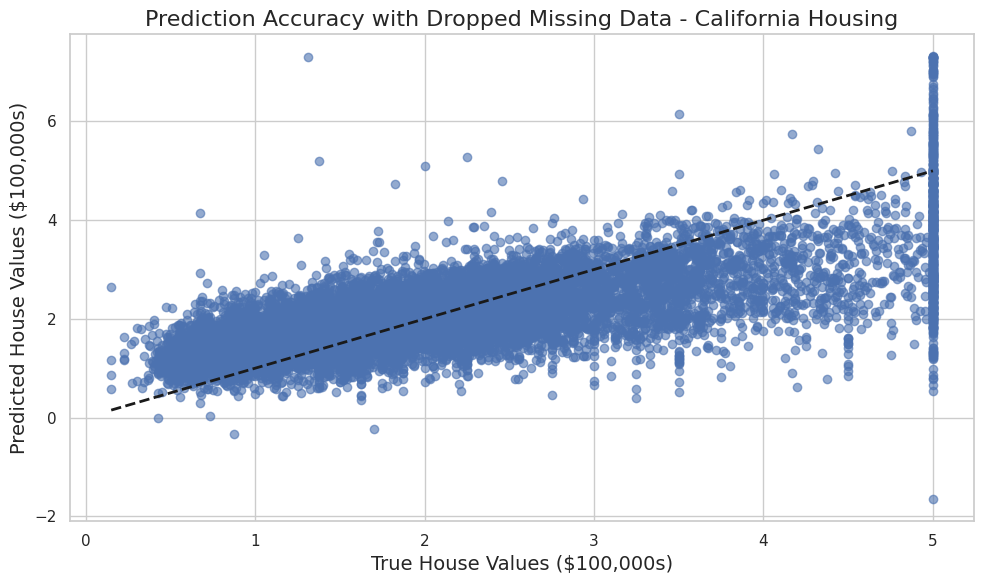


Model Performance:
Mean Squared Error: 0.6411
R² Score: 0.5135

Model Coefficients:
    Feature  Coefficient
0    MedInc     0.440197
1  HouseAge     0.017202
2  AveRooms    -0.021405


<Figure size 800x500 with 0 Axes>

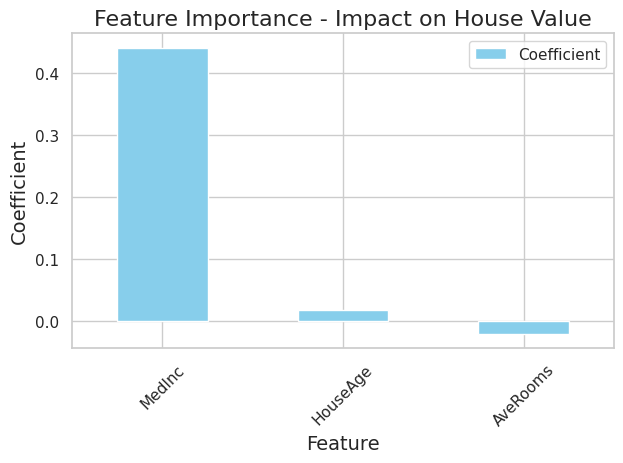

In [ ]:


# Remove rows with missing values (a common but often problematic approach)
X_dropna = X[~X.isnull().any(axis=1) & ~y.isnull()]
y_dropna = y[~X.isnull().any(axis=1) & ~y.isnull()]  # Ensure target aligns with features

print(f"\nOriginal dataset shape: {X.shape}")
print(f"Dataset shape after dropping missing values: {X_dropna.shape}")
print(f"Data loss: {(1 - len(X_dropna)/len(X))*100:.2f}%")

# Now fit the model with the cleaned data
model.fit(X_dropna, y_dropna)

# Make predictions
predictions = model.predict(X_dropna)

# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_dropna, predictions, alpha=0.6)
plt.plot([y_dropna.min(), y_dropna.max()], [y_dropna.min(), y_dropna.max()], 'k--', lw=2)
plt.xlabel('True House Values ($100,000s)', fontsize=14)
plt.ylabel('Predicted House Values ($100,000s)', fontsize=14)
plt.title('Prediction Accuracy with Dropped Missing Data - California Housing', fontsize=16)
plt.tight_layout()
plt.show()

# Calculate and display model metrics
mse = mean_squared_error(y_dropna, predictions)
r2 = r2_score(y_dropna, predictions)
print(f"\nModel Performance:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

# Display model coefficients to understand feature importance
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_
})
print("\nModel Coefficients:")
print(coef_df)

# Visualize feature importance
plt.figure(figsize=(8, 5))
coef_df.plot(x='Feature', y='Coefficient', kind='bar', color='skyblue')
plt.title('Feature Importance - Impact on House Value', fontsize=16)
plt.ylabel('Coefficient', fontsize=14)
plt.xlabel('Feature', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##Step 2: Exploring Solutions: Imputation and More

**Common Imputation Methods**

Remember, there is no perfect method for data imputation - some are more appropriate than others depending on the context and data.

Here's a brief overview of the methods used to handle missing data:

* **Drop NA:** Removes entire rows or columns containing any missing values. Simple, but can lead to significant data loss if many rows have even one missing value.
* **Mean Imputation:** Replaces missing values with the average of the non-missing data in that feature. Easy and fast, but can distort the distribution and reduce variance.
* **Median Imputation:** Replaces missing values with the median of the non-missing data in that feature. More robust to outliers than mean imputation and better for skewed distributions.
* **KNN Imputation:** Estimates a missing value based on the values of its 'K' nearest neighbors in the dataset. Can capture complex relationships but is computationally more intensive.
* **MICE (Iterative Imputer):** Models each feature with missing data using other features in an iterative process. A sophisticated method that predicts missing values while accounting for relationships between variables.

In [ ]:
import ipywidgets as widgets
from IPython.display import display, HTML

#there are null values in the target variable, so we need to drop those rows
X = X[~y.isnull()]
y = y[~y.isnull()]

# Function to evaluate model performance
def evaluate_model(X_imputed, y_valid):
    model = LinearRegression()
    model.fit(X_imputed, y_valid)
    predictions = model.predict(X_imputed)
    mse = mean_squared_error(y_valid, predictions)
    r2 = r2_score(y_valid, predictions)
    return model, predictions, mse, r2

# Function to update outputs based on widget interaction
def update_output(method):
    plt.figure(figsize=(12, 8))

    # Create two subplots
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)

    # Handle the selected imputation method
    if method == "Drop NA":
        # Remove rows with missing values
        X_clean = X[~X.isnull().any(axis=1) & ~y.isnull()]
        y_clean = y[~X.isnull().any(axis=1) & ~y.isnull()]
        model, predictions, mse, r2 = evaluate_model(X_clean, y_clean)
        method_desc = "Drops all rows with any missing values. Simple but can lead to significant data loss."

        # Show data loss in first plot
        data_loss = (1 - len(X_clean)/len(X)) * 100
        ax1.bar(['Original', 'After Dropping'], [len(X), len(X_clean)])
        ax1.set_title(f'Data Count\n(Lost {data_loss:.1f}% of data)')
        ax1.set_ylabel('Number of Records')

    elif method == "Mean":
        imputer = SimpleImputer(strategy='mean')
        X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
        model, predictions, mse, r2 = evaluate_model(X_imputed, y)
        method_desc = "Replaces missing values with the mean of each column. Simple but can distort distributions."

        # Show before/after distribution
        for col in features:
            sns.kdeplot(X[col].dropna(), ax=ax1, label=f'Original {col}')
            sns.kdeplot(X_imputed[col], ax=ax1, linestyle='--', label=f'Imputed {col}')
        ax1.set_title('Distribution Before vs After Imputation')
        ax1.legend()

    elif method == "Median":
        imputer = SimpleImputer(strategy='median')
        X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
        model, predictions, mse, r2 = evaluate_model(X_imputed, y)
        method_desc = "Replaces missing values with the median of each column. More robust to outliers than mean."

        # Show before/after distribution
        for col in features:
            sns.kdeplot(X[col].dropna(), ax=ax1, label=f'Original {col}')
            sns.kdeplot(X_imputed[col], ax=ax1, linestyle='--', label=f'Imputed {col}')
        ax1.set_title('Distribution Before vs After Imputation')
        ax1.legend()

    elif method == "KNN":
        imputer = KNNImputer(n_neighbors=5)
        X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
        model, predictions, mse, r2 = evaluate_model(X_imputed, y)
        method_desc = "Uses K-nearest neighbors to estimate missing values. Preserves relationships but computationally intensive."

        # Show before/after distribution
        for col in features:
            sns.kdeplot(X[col].dropna(), ax=ax1, label=f'Original {col}')
            sns.kdeplot(X_imputed[col], ax=ax1, linestyle='--', label=f'Imputed {col}')
        ax1.set_title('Distribution Before vs After Imputation')
        ax1.legend()

    elif method == "MICE":
        imputer = IterativeImputer(random_state=42, max_iter=10)
        X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
        model, predictions, mse, r2 = evaluate_model(X_imputed, y)
        method_desc = "Multiple Imputation by Chained Equations. Uses multiple variables to predict missing values. Sophisticated approach."

        # Show before/after distribution
        for col in features:
            sns.kdeplot(X[col].dropna(), ax=ax1, label=f'Original {col}')
            sns.kdeplot(X_imputed[col], ax=ax1, linestyle='--', label=f'Imputed {col}')
        ax1.set_title('Distribution Before vs After Imputation')
        ax1.legend()

    # Plot model predictions in second plot
    if method == "Drop NA":
        ax2.scatter(y_clean, predictions, alpha=0.5)
        ax2.plot([y_clean.min(), y_clean.max()], [y_clean.min(), y_clean.max()], 'k--')
        y_data = y_clean
    else:
        ax2.scatter(y, predictions, alpha=0.5)
        ax2.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
        y_data = y

    ax2.set_xlabel('Actual House Values')
    ax2.set_ylabel('Predicted House Values')
    ax2.set_title(f'Model Performance\nMSE: {mse:.2f}, R²: {r2:.2f}')

    plt.tight_layout()
    plt.show()

    # Display feature importance and method description
    if method != "Drop NA":
        coef_df = pd.DataFrame({'Feature': features, 'Coefficient': model.coef_})
        display(HTML(f"<h4>Feature Importance:</h4>"))
        display(coef_df)

    display(HTML(f"<h4>About {method} Imputation:</h4><p>{method_desc}</p>"))

# Create dropdown widget for imputation method selection
method_widget = widgets.Dropdown(
    options=['Drop NA', 'Mean', 'Median', 'KNN', 'MICE'],
    value='Mean',
    description='Method:',
    style={'description_width': 'initial'},
    layout={'width': '300px'}
)

# Display missing data information
print("Missing values in dataset:")
display(X.isna().sum())

# Create output widget and interactive function
output = widgets.Output()
out = widgets.interactive_output(update_output, {'method': method_widget})

# Display the interactive widget
display(HTML("<h2>Interactive Missing Data Solution Explorer - California Housing Dataset</h2>"))
display(HTML("<p>Select different methods to handle missing data and compare their impact on model performance.</p>"))
display(widgets.VBox([method_widget, out]))

# Add explanatory text
display(HTML("""
<div style="background-color: #f5f5f5; padding: 10px; border-radius: 5px; margin-top: 20px;">
<h3>How to Use This Explorer:</h3>
<ol>
    <li>Select an imputation method from the dropdown menu</li>
    <li>Observe how the data distribution changes in the left plot</li>
    <li>Compare model performance metrics and prediction accuracy in the right plot</li>
    <li>Review feature importance and method description below the plots</li>
</ol>
<p><strong>Note:</strong> The best imputation method often depends on your specific dataset and use case.</p>
</div>
"""))

Missing values in dataset:


,0
MedInc,1837
HouseAge,1876
AveRooms,1806


In [ ]:
# Create a function to compare multiple methods at once
def compare_methods():
    methods = ['Drop NA', 'Mean', 'Median', 'KNN', 'MICE']
    results = {}

    for method in methods:
        if method == "Drop NA":
            X_clean = X.dropna()
            y_clean = y[X_clean.index]
            _, _, mse, r2 = evaluate_model(X_clean, y_clean)
            data_retained = len(X_clean) / len(X) * 100
            results[method] = {
                'MSE': mse,
                'R²': r2,
                'Data Retained (%)': data_retained
            }
        elif method == "Mean":
            imputer = SimpleImputer(strategy='mean')
            X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
            _, _, mse, r2 = evaluate_model(X_imputed, y)
            results[method] = {'MSE': mse, 'R²': r2, 'Data Retained (%)': 100}
        elif method == "Median":
            imputer = SimpleImputer(strategy='median')
            X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
            _, _, mse, r2 = evaluate_model(X_imputed, y)
            results[method] = {'MSE': mse, 'R²': r2, 'Data Retained (%)': 100}
        elif method == "KNN":
            imputer = KNNImputer(n_neighbors=5)
            X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
            _, _, mse, r2 = evaluate_model(X_imputed, y)
            results[method] = {'MSE': mse, 'R²': r2, 'Data Retained (%)': 100}
        elif method == "MICE":
            imputer = IterativeImputer(random_state=42, max_iter=10)
            X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
            _, _, mse, r2 = evaluate_model(X_imputed, y)
            results[method] = {'MSE': mse, 'R²': r2, 'Data Retained (%)': 100}

    # Convert results to DataFrame for visualization
    results_df = pd.DataFrame(results).T

    # Create comparison plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # MSE comparison (lower is better)
    results_df['MSE'].plot(kind='bar', ax=axes[0], color='salmon')
    axes[0].set_title('Mean Squared Error (Lower is Better)')
    axes[0].set_ylabel('MSE')

    # R² comparison (higher is better)
    results_df['R²'].plot(kind='bar', ax=axes[1], color='skyblue')
    axes[1].set_title('R² Score (Higher is Better)')
    axes[1].set_ylabel('R²')

    # Data retention comparison
    results_df['Data Retained (%)'].plot(kind='bar', ax=axes[2], color='lightgreen')
    axes[2].set_title('Data Retention')
    axes[2].set_ylabel('Percentage (%)')

    plt.tight_layout()
    plt.show()

    return results_df

# Create a button to trigger method comparison
compare_button = widgets.Button(
    description='Compare All Methods',
    button_style='success',
    tooltip='Click to compare all imputation methods'
)

def on_compare_button_click(b):
    display(HTML("<h3>Imputation Method Comparison Results</h3>"))
    results_df = compare_methods()
    display(results_df)

compare_button.on_click(on_compare_button_click)
display(compare_button)

Button(button_style='success', description='Compare All Methods', style=ButtonStyle(), tooltip='Click to compa…